In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

In [3]:
tf.random.set_seed(1979)

In [4]:
# number of the state variables
nx = 4
# number of the input variables
nu = 1
# number of the scheduling variables
ns = 1

## Load and Split Data

In [5]:
X = np.load('Xdata.npy')
XP = np.load('XPdata.npy')
U = np.load('Udata.npy')

In [6]:
print(f'The shape for the X dataset {X.shape}')
print(f'The shape for the XP dataset {XP.shape}')
print(f'The shape for the U dataset {U.shape}')

The shape for the X dataset (1980000, 4)
The shape for the XP dataset (1980000, 4)
The shape for the U dataset (1980000, 1)


In [7]:
X_tra, X_tes, XP_tra, XP_tes, U_tra, U_tes  = train_test_split(X, XP, U, test_size=0.01,
                                                               shuffle=True, random_state=1979)

## Scale Input

In [8]:
scaler_x = MaxAbsScaler()
scaler_u = MaxAbsScaler()

X_tra_sca = scaler_x.fit_transform(X_tra)
X_tes_sca = scaler_x.transform(X_tes)

U_tra_sca = scaler_u.fit_transform(U_tra)
U_tes_sca = scaler_u.transform(U_tes)

# Autoencoder Model

## Encoder

In [10]:
tf.keras.backend.clear_session()

def encoder_layers(nx, ns, inputs):
    enco_dense1 = tf.keras.layers.Dense(units=20, activation='relu')(inputs)
    enco_dense2 = tf.keras.layers.Dense(units=10, activation='relu')(enco_dense1)
    scheduling_var = tf.keras.layers.Dense(units=ns, activation='relu', use_bias=False)(enco_dense2)
    return scheduling_var

def encoder(nx, ns):
    inputs = tf.keras.layers.Input(shape=(nx,), name='State Vector')
    scheduling_var = encoder_layers(nx, ns, inputs)
    encoder_model = tf.keras.models.Model(inputs=inputs, outputs=scheduling_var, name='Encoder')
    return encoder_model

# Create an encoder model
encoder_model = encoder(nx, ns)

encoder_model.summary()
tf.keras.utils.plot_model(encoder_model)

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 State Vector (InputLayer)   [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 20)                100       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 10        
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Decoder

In [11]:
def decoder(nx, nu, ns):
    X = tf.keras.layers.Input(shape=(nx,), name='X')
    U = tf.keras.layers.Input(shape=(nu,), name='U')
    Scheduling_var = tf.keras.layers.Input(shape=(ns,), name='scheduling variables')
    
    XU = tf.keras.layers.concatenate([X, U], axis=1)
    deco_dense = tf.keras.layers.Dense(units= nx * (nx + nu), activation='linear', name='AB_matrices',
                       kernel_constraint=tf.keras.constraints.MinMaxNorm(min_value=1e-3, axis=[0,1]), 
                       use_bias=True)(Scheduling_var)
    reshape_out = tf.keras.layers.Reshape(target_shape=(nx, nx + nu))(deco_dense)
    outputs = tf.keras.layers.dot([reshape_out, XU ], axes=(2,1))
    decoder_model = tf.keras.models.Model(inputs=[Scheduling_var, X, U], outputs=outputs, name='Decoder')
    return decoder_model

# Create a decoder model
decoder_model =  decoder(nx, nu, ns)

decoder_model.summary()
tf.keras.utils.plot_model(decoder_model)

Model: "Decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 scheduling variables (InputLay  [(None, 1)]         0           []                               
 er)                                                                                              
                                                                                                  
 AB_matrices (Dense)            (None, 20)           40          ['scheduling variables[0][0]']   
                                                                                                  
 X (InputLayer)                 [(None, 4)]          0           []                               
                                                                                                  
 U (InputLayer)                 [(None, 1)]          0           []                         

## Build Model

In [13]:
X = tf.keras.layers.Input(shape=(nx,), name='X input')
U = tf.keras.layers.Input(shape=(nu,), name='U input')

scheduling_var = encoder_model(X)

outputs = decoder_model([scheduling_var, X, U])

autoencoder_model = tf.keras.models.Model(inputs=[X, U], outputs=outputs, name='Autoencoder')

tf.keras.utils.plot_model(autoencoder_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Train Model

In [14]:
best_model_callback = tf.keras.callbacks.ModelCheckpoint('LPV_model.h5', monitor='val_mae', 
                                                         save_best_only=True, verbose=1)

optimizer = tf.keras.optimizers.Adam()

autoencoder_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = autoencoder_model.fit(x=(X_tra_sca, U_tra_sca), y=XP_tra, epochs=300, batch_size=1024, validation_split=0.2,
                                callbacks=[best_model_callback])


Epoch 1/300
1526/1532 [============================>.] - ETA: 0s - loss: 0.0152 - mae: 0.0179
Epoch 1: val_mae improved from inf to 0.00316, saving model to LPV_model.h5
1532/1532 [==============================] - 8s 4ms/step - loss: 0.0151 - mae: 0.0178 - val_loss: 0.0012 - val_mae: 0.0032
Epoch 2/300
1527/1532 [============================>.] - ETA: 0s - loss: 9.1503e-04 - mae: 0.0031
Epoch 2: val_mae improved from 0.00316 to 0.00291, saving model to LPV_model.h5
1532/1532 [==============================] - 6s 4ms/step - loss: 9.1419e-04 - mae: 0.0031 - val_loss: 6.6285e-04 - val_mae: 0.0029
Epoch 3/300
1525/1532 [============================>.] - ETA: 0s - loss: 5.0750e-04 - mae: 0.0026
Epoch 3: val_mae improved from 0.00291 to 0.00224, saving model to LPV_model.h5
1532/1532 [==============================] - 7s 4ms/step - loss: 5.0641e-04 - mae: 0.0026 - val_loss: 3.7073e-04 - val_mae: 0.0022
Epoch 4/300
1525/1532 [============================>.] - ETA: 0s - loss: 2.7857e-04 - mae

1518/1532 [============================>.] - ETA: 0s - loss: 1.8904e-05 - mae: 5.9154e-04
Epoch 28: val_mae did not improve from 0.00054
1532/1532 [==============================] - 8s 5ms/step - loss: 1.8897e-05 - mae: 5.9184e-04 - val_loss: 1.9864e-05 - val_mae: 5.8646e-04
Epoch 29/300
1526/1532 [============================>.] - ETA: 0s - loss: 1.8621e-05 - mae: 5.8662e-04
Epoch 29: val_mae improved from 0.00054 to 0.00052, saving model to LPV_model.h5
1532/1532 [==============================] - 6s 4ms/step - loss: 1.8613e-05 - mae: 5.8654e-04 - val_loss: 1.7245e-05 - val_mae: 5.1996e-04
Epoch 30/300
1524/1532 [============================>.] - ETA: 0s - loss: 1.8080e-05 - mae: 5.7614e-04
Epoch 30: val_mae did not improve from 0.00052
1532/1532 [==============================] - 7s 4ms/step - loss: 1.8071e-05 - mae: 5.7625e-04 - val_loss: 1.7549e-05 - val_mae: 5.7422e-04
Epoch 31/300
1520/1532 [============================>.] - ETA: 0s - loss: 1.7834e-05 - mae: 5.7481e-04
Epoch 31:

1532/1532 [==============================] - 5s 3ms/step - loss: 1.2545e-05 - mae: 4.7884e-04 - val_loss: 1.3387e-05 - val_mae: 4.9147e-04
Epoch 56/300
1531/1532 [============================>.] - ETA: 0s - loss: 1.2395e-05 - mae: 4.7597e-04
Epoch 56: val_mae did not improve from 0.00041
1532/1532 [==============================] - 6s 4ms/step - loss: 1.2393e-05 - mae: 4.7596e-04 - val_loss: 1.6270e-05 - val_mae: 6.9004e-04
Epoch 57/300
1528/1532 [============================>.] - ETA: 0s - loss: 1.2151e-05 - mae: 4.6433e-04
Epoch 57: val_mae did not improve from 0.00041
1532/1532 [==============================] - 7s 4ms/step - loss: 1.2196e-05 - mae: 4.6458e-04 - val_loss: 1.1576e-05 - val_mae: 4.9102e-04
Epoch 58/300
1525/1532 [============================>.] - ETA: 0s - loss: 1.2002e-05 - mae: 4.5973e-04
Epoch 58: val_mae improved from 0.00041 to 0.00040, saving model to LPV_model.h5
1532/1532 [==============================] - 7s 4ms/step - loss: 1.1983e-05 - mae: 4.5960e-04 - val

Epoch 83/300
1527/1532 [============================>.] - ETA: 0s - loss: 8.9100e-06 - mae: 3.4254e-04
Epoch 83: val_mae improved from 0.00028 to 0.00027, saving model to LPV_model.h5
1532/1532 [==============================] - 9s 6ms/step - loss: 8.9147e-06 - mae: 3.4231e-04 - val_loss: 7.7151e-06 - val_mae: 2.7245e-04
Epoch 84/300
1530/1532 [============================>.] - ETA: 0s - loss: 8.7860e-06 - mae: 3.3792e-04
Epoch 84: val_mae did not improve from 0.00027
1532/1532 [==============================] - 11s 7ms/step - loss: 8.7802e-06 - mae: 3.3782e-04 - val_loss: 8.4205e-06 - val_mae: 3.0782e-04
Epoch 85/300
1523/1532 [============================>.] - ETA: 0s - loss: 8.7793e-06 - mae: 3.3480e-04
Epoch 85: val_mae did not improve from 0.00027
1532/1532 [==============================] - 8s 6ms/step - loss: 8.7775e-06 - mae: 3.3505e-04 - val_loss: 9.0317e-06 - val_mae: 3.4267e-04
Epoch 86/300
1528/1532 [============================>.] - ETA: 0s - loss: 8.8358e-06 - mae: 3.4065

Epoch 111/300
1525/1532 [============================>.] - ETA: 0s - loss: 6.9894e-06 - mae: 3.1950e-04
Epoch 111: val_mae did not improve from 0.00023
1532/1532 [==============================] - 6s 4ms/step - loss: 6.9953e-06 - mae: 3.1955e-04 - val_loss: 6.4803e-06 - val_mae: 3.2217e-04
Epoch 112/300
1526/1532 [============================>.] - ETA: 0s - loss: 6.9700e-06 - mae: 3.1732e-04
Epoch 112: val_mae did not improve from 0.00023
1532/1532 [==============================] - 7s 5ms/step - loss: 6.9607e-06 - mae: 3.1712e-04 - val_loss: 7.2878e-06 - val_mae: 3.3124e-04
Epoch 113/300
1530/1532 [============================>.] - ETA: 0s - loss: 6.8364e-06 - mae: 3.1829e-04
Epoch 113: val_mae did not improve from 0.00023
1532/1532 [==============================] - 9s 6ms/step - loss: 6.8367e-06 - mae: 3.1825e-04 - val_loss: 6.3585e-06 - val_mae: 2.6672e-04
Epoch 114/300
1518/1532 [============================>.] - ETA: 0s - loss: 6.6030e-06 - mae: 3.0564e-04
Epoch 114: val_mae did 

1532/1532 [==============================] - ETA: 0s - loss: 4.8557e-06 - mae: 2.9824e-04
Epoch 139: val_mae did not improve from 0.00022
1532/1532 [==============================] - 7s 4ms/step - loss: 4.8557e-06 - mae: 2.9824e-04 - val_loss: 5.3252e-06 - val_mae: 4.9958e-04
Epoch 140/300
1526/1532 [============================>.] - ETA: 0s - loss: 4.6671e-06 - mae: 2.8770e-04
Epoch 140: val_mae did not improve from 0.00022
1532/1532 [==============================] - 9s 6ms/step - loss: 4.6778e-06 - mae: 2.8776e-04 - val_loss: 4.3359e-06 - val_mae: 2.6424e-04
Epoch 141/300
1526/1532 [============================>.] - ETA: 0s - loss: 4.7620e-06 - mae: 3.0064e-04
Epoch 141: val_mae did not improve from 0.00022
1532/1532 [==============================] - 20s 13ms/step - loss: 4.7646e-06 - mae: 3.0092e-04 - val_loss: 5.9576e-06 - val_mae: 3.9161e-04
Epoch 142/300
1529/1532 [============================>.] - ETA: 0s - loss: 4.5291e-06 - mae: 2.8000e-04
Epoch 142: val_mae did not improve 

1528/1532 [============================>.] - ETA: 0s - loss: 3.4627e-06 - mae: 2.7504e-04
Epoch 167: val_mae did not improve from 0.00021
1532/1532 [==============================] - 7s 5ms/step - loss: 3.4603e-06 - mae: 2.7495e-04 - val_loss: 3.1719e-06 - val_mae: 2.4549e-04
Epoch 168/300
1532/1532 [==============================] - ETA: 0s - loss: 3.2342e-06 - mae: 2.5699e-04
Epoch 168: val_mae did not improve from 0.00021
1532/1532 [==============================] - 10s 6ms/step - loss: 3.2342e-06 - mae: 2.5699e-04 - val_loss: 3.6983e-06 - val_mae: 3.9948e-04
Epoch 169/300
1524/1532 [============================>.] - ETA: 0s - loss: 3.3458e-06 - mae: 2.7083e-04
Epoch 169: val_mae did not improve from 0.00021
1532/1532 [==============================] - 8s 5ms/step - loss: 3.3427e-06 - mae: 2.7072e-04 - val_loss: 2.7992e-06 - val_mae: 2.3548e-04
Epoch 170/300
1527/1532 [============================>.] - ETA: 0s - loss: 3.2820e-06 - mae: 2.6547e-04
Epoch 170: val_mae did not improve f

1524/1532 [============================>.] - ETA: 0s - loss: 2.9226e-06 - mae: 2.6063e-04
Epoch 195: val_mae did not improve from 0.00019
1532/1532 [==============================] - 6s 4ms/step - loss: 2.9237e-06 - mae: 2.6113e-04 - val_loss: 3.0332e-06 - val_mae: 3.8952e-04
Epoch 196/300
1527/1532 [============================>.] - ETA: 0s - loss: 2.9139e-06 - mae: 2.5423e-04
Epoch 196: val_mae did not improve from 0.00019
1532/1532 [==============================] - 7s 4ms/step - loss: 2.9135e-06 - mae: 2.5430e-04 - val_loss: 2.9173e-06 - val_mae: 2.1385e-04
Epoch 197/300
1526/1532 [============================>.] - ETA: 0s - loss: 2.8678e-06 - mae: 2.5731e-04
Epoch 197: val_mae did not improve from 0.00019
1532/1532 [==============================] - 7s 4ms/step - loss: 2.8675e-06 - mae: 2.5726e-04 - val_loss: 2.6276e-06 - val_mae: 2.3437e-04
Epoch 198/300
1528/1532 [============================>.] - ETA: 0s - loss: 2.8885e-06 - mae: 2.4794e-04
Epoch 198: val_mae did not improve fr

1524/1532 [============================>.] - ETA: 0s - loss: 2.4627e-06 - mae: 2.4616e-04
Epoch 223: val_mae did not improve from 0.00018
1532/1532 [==============================] - 6s 4ms/step - loss: 2.4589e-06 - mae: 2.4589e-04 - val_loss: 2.5295e-06 - val_mae: 2.0848e-04
Epoch 224/300
1526/1532 [============================>.] - ETA: 0s - loss: 2.4752e-06 - mae: 2.4233e-04
Epoch 224: val_mae did not improve from 0.00018
1532/1532 [==============================] - 7s 4ms/step - loss: 2.4762e-06 - mae: 2.4235e-04 - val_loss: 2.9506e-06 - val_mae: 2.3275e-04
Epoch 225/300
1531/1532 [============================>.] - ETA: 0s - loss: 2.5507e-06 - mae: 2.4763e-04
Epoch 225: val_mae did not improve from 0.00018
1532/1532 [==============================] - 7s 5ms/step - loss: 2.5510e-06 - mae: 2.4764e-04 - val_loss: 2.0312e-06 - val_mae: 2.5147e-04
Epoch 226/300
1522/1532 [============================>.] - ETA: 0s - loss: 2.4049e-06 - mae: 2.3925e-04
Epoch 226: val_mae improved from 0.00

1528/1532 [============================>.] - ETA: 0s - loss: 2.1979e-06 - mae: 2.2961e-04
Epoch 251: val_mae did not improve from 0.00018
1532/1532 [==============================] - 6s 4ms/step - loss: 2.1963e-06 - mae: 2.2952e-04 - val_loss: 2.0919e-06 - val_mae: 2.0113e-04
Epoch 252/300
1525/1532 [============================>.] - ETA: 0s - loss: 2.3179e-06 - mae: 2.4114e-04
Epoch 252: val_mae did not improve from 0.00018
1532/1532 [==============================] - 6s 4ms/step - loss: 2.3169e-06 - mae: 2.4100e-04 - val_loss: 1.9337e-06 - val_mae: 2.0436e-04
Epoch 253/300
1528/1532 [============================>.] - ETA: 0s - loss: 2.2582e-06 - mae: 2.2799e-04
Epoch 253: val_mae did not improve from 0.00018
1532/1532 [==============================] - 7s 4ms/step - loss: 2.2565e-06 - mae: 2.2793e-04 - val_loss: 2.0600e-06 - val_mae: 1.9092e-04
Epoch 254/300
1524/1532 [============================>.] - ETA: 0s - loss: 2.2047e-06 - mae: 2.3737e-04
Epoch 254: val_mae did not improve fr

1525/1532 [============================>.] - ETA: 0s - loss: 1.9138e-06 - mae: 2.2427e-04
Epoch 279: val_mae did not improve from 0.00017
1532/1532 [==============================] - 6s 4ms/step - loss: 1.9186e-06 - mae: 2.2464e-04 - val_loss: 2.0067e-06 - val_mae: 2.7541e-04
Epoch 280/300
1519/1532 [============================>.] - ETA: 0s - loss: 1.8618e-06 - mae: 2.0977e-04
Epoch 280: val_mae did not improve from 0.00017
1532/1532 [==============================] - 6s 4ms/step - loss: 1.8668e-06 - mae: 2.0988e-04 - val_loss: 3.0784e-06 - val_mae: 2.9554e-04
Epoch 281/300
1522/1532 [============================>.] - ETA: 0s - loss: 1.9214e-06 - mae: 2.1861e-04
Epoch 281: val_mae did not improve from 0.00017
1532/1532 [==============================] - 6s 4ms/step - loss: 1.9179e-06 - mae: 2.1848e-04 - val_loss: 1.4997e-06 - val_mae: 2.2010e-04
Epoch 282/300
1520/1532 [============================>.] - ETA: 0s - loss: 1.8826e-06 - mae: 2.1716e-04
Epoch 282: val_mae did not improve fr

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


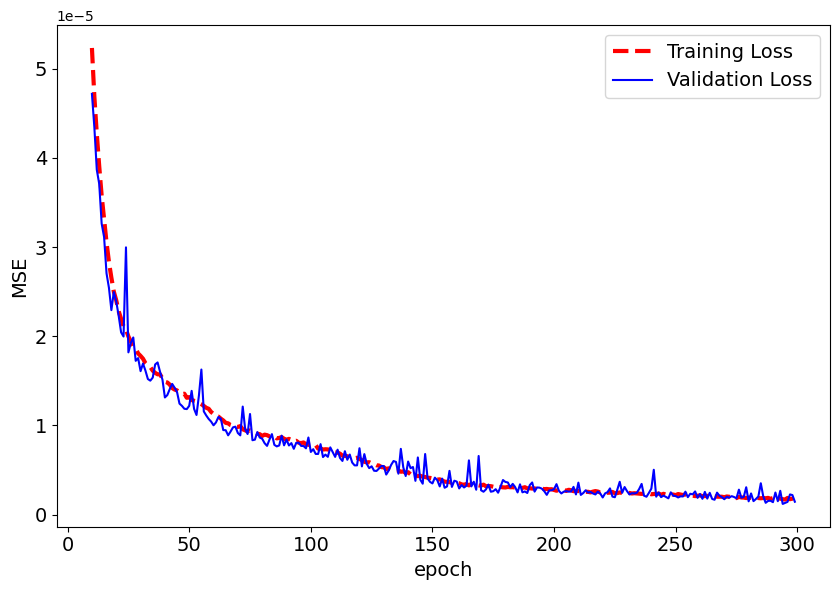

In [16]:
fig, axs = plt.subplots(1,1, figsize=(8.5,6))
axs.plot(range(10,len(history.history['loss'])), history.history['loss'][10:], 'r--', linewidth=3,  label='Training Loss')
axs.plot(range(10, len(history.history['val_loss'])), history.history['val_loss'][10:], 'b', label='Validation Loss')
axs.legend(fontsize=14)

axs.set_ylabel('MSE', fontsize=14)
axs.set_xlabel('epoch', fontsize=14)
axs.xaxis.set_tick_params(labelsize=14)
axs.yaxis.set_tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('MSE-LPV.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


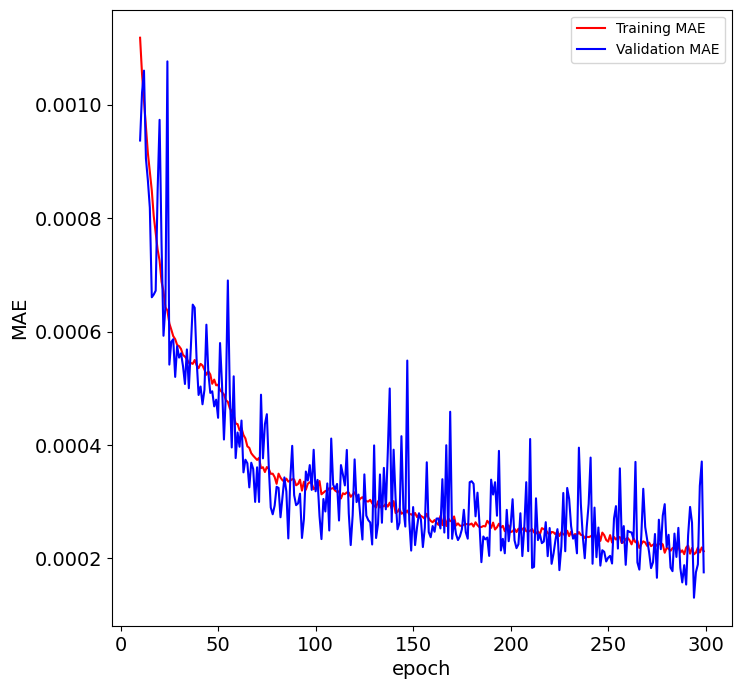

In [17]:
fig, axs = plt.subplots(1,1, figsize=(8,8))

axs.plot(range(10, len(history.history['mae'])), history.history['mae'][10:], 'r', label='Training MAE')
axs.plot(range(10, len(history.history['val_mae'])), history.history['val_mae'][10:], 'b', label='Validation MAE')
axs.legend()

axs.set_ylabel('MAE', fontsize=14)
axs.set_xlabel('epoch', fontsize=14)
axs.xaxis.set_tick_params(labelsize=14)
axs.yaxis.set_tick_params(labelsize=14)
plt.savefig('MAE-LPV.eps')
plt.show()

In [18]:
autoencoder_model.load_weights('LPV_model.h5')
autoencoder_model.evaluate((X_tes_sca, U_tes_sca), XP_tes)

619/619 [==============================] - 1s 2ms/step - loss: 1.0249e-06 - mae: 1.2514e-04


[1.0248659236822277e-06, 0.00012513526598922908]

In [19]:
def A_B_matrices(scal_x, scal_u, bias=False):
    Res = {}
    A_B = decoder_model.get_layer('AB_matrices').get_weights()[0]
   
    for i in range(ns):
        Res['A' + str(i+1)] = A_B[i].reshape((nx, nx + nu))[:,:nx].dot(np.linalg.inv(scal_x))
        Res['B' + str(i+1)] = A_B[i].reshape((nx, nx + nu))[:,nx:].dot(np.linalg.inv(scal_u))
            
    if bias:
        A_B_bias = decoder_model.get_layer('AB_matrices').get_weights()[1]
        Res['A0'] = A_B_bias.reshape((nx, nx + nu))[:,:nx].dot(np.linalg.inv(scal_x))
        Res['B0'] = A_B_bias.reshape((nx, nx + nu))[:,nx:].dot(np.linalg.inv(scal_u))
    return Res

# to scale the matrix 
scal_x = np.diag(scaler_x.max_abs_)
scal_u = np.diag(scaler_u.max_abs_)
Res = A_B_matrices(scal_x, scal_u, bias=True) 

for key, value in Res.items():
    print(key, ': \n', value  )

A1 : 
 [[ 6.50496867e-04  1.59965123e-04  1.07194341e-05  3.46548093e-04]
 [-1.98233134e-01  7.41756358e-02  5.75519568e-03  1.52496813e-01]
 [-1.73266402e-04 -4.23950264e-05 -7.27777269e-06 -9.24853576e-05]
 [ 1.17993211e-02 -7.55409391e-03  2.84323519e-03 -1.42960577e-02]]
B1 : 
 [[-8.84453544e-06]
 [-4.59124985e-03]
 [ 2.26031961e-06]
 [ 4.16206072e-04]]
A0 : 
 [[ 9.90342656e-01  4.76720298e-02 -1.61118452e-04 -5.02048854e-03]
 [ 4.27156566e+00 -1.16652933e-01 -8.82052832e-02 -7.66508901e-02]
 [ 2.58009654e-03  6.22588118e-04  1.00009620e+00  5.13593024e-02]
 [-2.14040374e-01  1.13605978e-01 -4.05933125e-02  3.80360512e-01]]
B0 : 
 [[ 1.24819657e-04]
 [-2.72996834e-02]
 [-3.23696439e-05]
 [ 3.02009469e-02]]


## Scheduling Variables

In [20]:
W0_sch = encoder_model.get_weights()[0]
# To take care of imapct the scaler on the state variables
# This way, one can use the original values for x to obtain the scheduling variables
W0_sch = (np.diag(1 / scaler_x.max_abs_)).dot(W0_sch)
b0_sch = encoder_model.get_weights()[1]

W1_sch = encoder_model.get_weights()[2]
b1_sch = encoder_model.get_weights()[3]

# Note that for the encoder, the bias=False for the third layer, so
# we don't have b3
W2_sch = encoder_model.get_weights()[4]

In [21]:
a1 = np.maximum(X_tes.dot(W0_sch) + b0_sch, 0)
a2 = np.maximum(a1.dot(W1_sch) + b1_sch, 0)
sch_pred = np.maximum(a2.dot(W2_sch), 0)

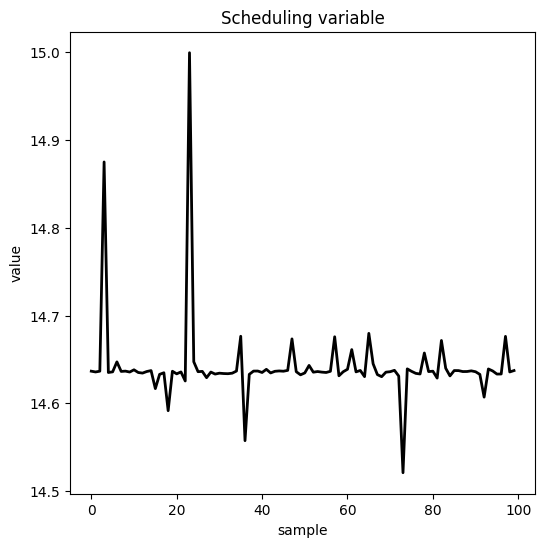

In [22]:
low_lim = 10300
up_lim = 10400

fig, axs = plt.subplots(figsize=(6,6))

axs.plot(sch_pred[low_lim:up_lim, 0], 'k', linewidth=2, label='computed')
axs.set(title='Scheduling variable')
axs.set_xlabel('sample')
axs.set_ylabel('value')
plt.savefig('SCH-LPV1.jpg')
plt.show()

In [23]:
XP_comp = np.zeros(X_tes.shape) 
for num, tet in enumerate(sch_pred):
    XP_comp[num, :] = (tet[0] * Res['A1'] + Res['A0']).dot(X_tes[num,:]) + (tet[0] * Res['B1'] + Res['B0']).dot(U_tes[num,:]) 

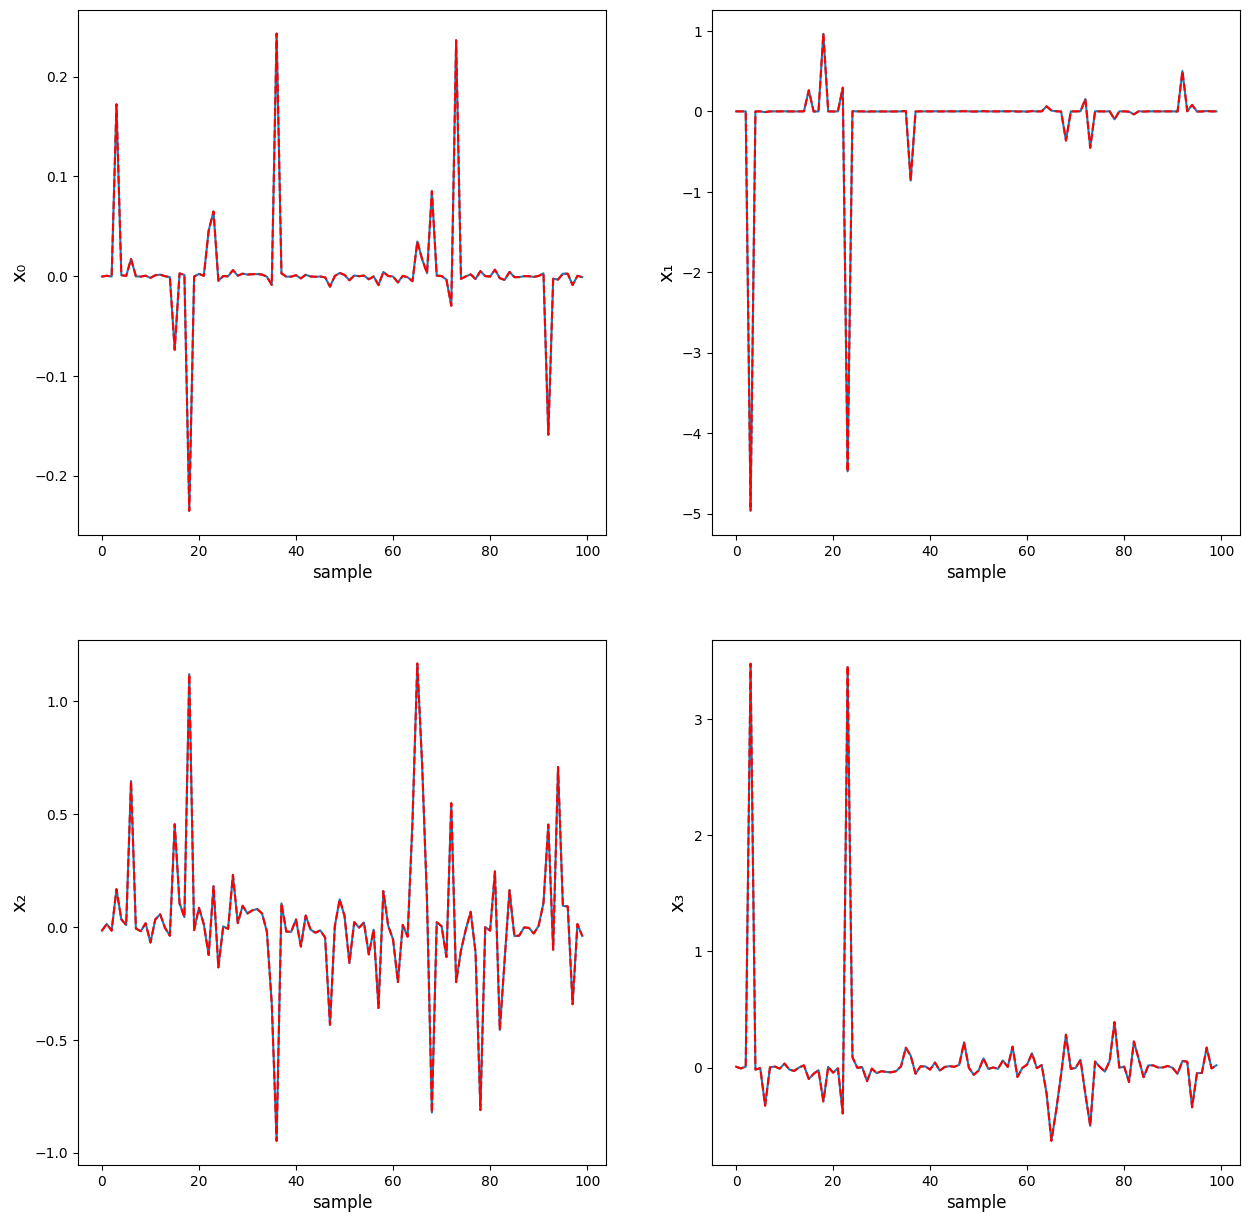

In [24]:
fig, axs = plt.subplots(2,2, figsize=(15,15))

axs = np.ravel(axs)
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
for ind in range(4):
    axs[ind].plot(XP_comp[low_lim:up_lim, ind])
    axs[ind].plot(XP_tes[low_lim:up_lim, ind], 'r--')
    axs[ind].set_xlabel('sample', size=12)
    axs[ind].set_ylabel(('x' + str(ind)).translate(SUB), size=14)
plt.savefig('COMP-LPV1.jpg')

## Produce figures of paper

In [25]:
Xfig = np.load('Xfig.npy')
Ufig = np.load('Ufig.npy')

print(f'The shape for the X dataset {Xfig.shape}')
print(f'The shape for the U dataset {Ufig.shape}')

The shape for the X dataset (149, 4)
The shape for the U dataset (149, 1)


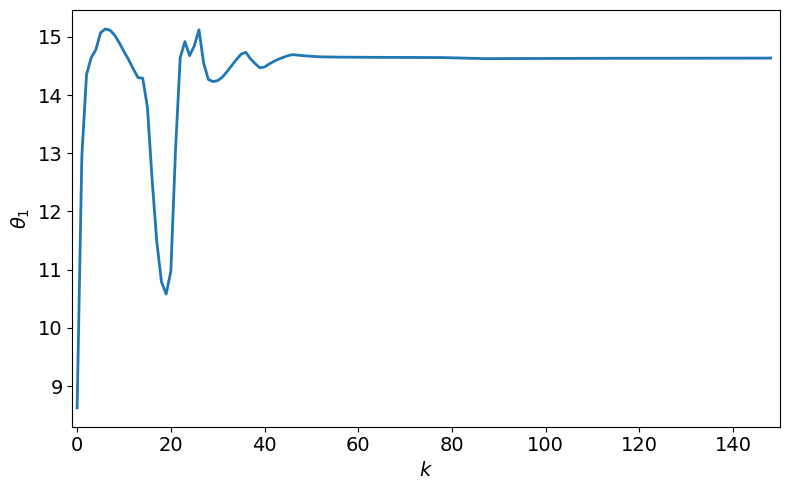

In [26]:
# Scheduling variable
a1 = np.maximum(Xfig.dot(W0_sch) + b0_sch, 0)
a2 = np.maximum(a1.dot(W1_sch) + b1_sch, 0)
sch_pred_fig = np.maximum(a2.dot(W2_sch), 0)

fig, axs = plt.subplots(figsize=(8,5))

axs.plot(sch_pred_fig, linewidth=2, label='computed')
axs.set_xlabel(r'$k$', fontsize=14)
axs.set_ylabel(r'$\theta_1$', fontsize=14)
axs.xaxis.set_tick_params(labelsize=14)
axs.yaxis.set_tick_params(labelsize=14)
axs.set_xlim(-1,150)
plt.tight_layout()
plt.savefig('SCH-FIG.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


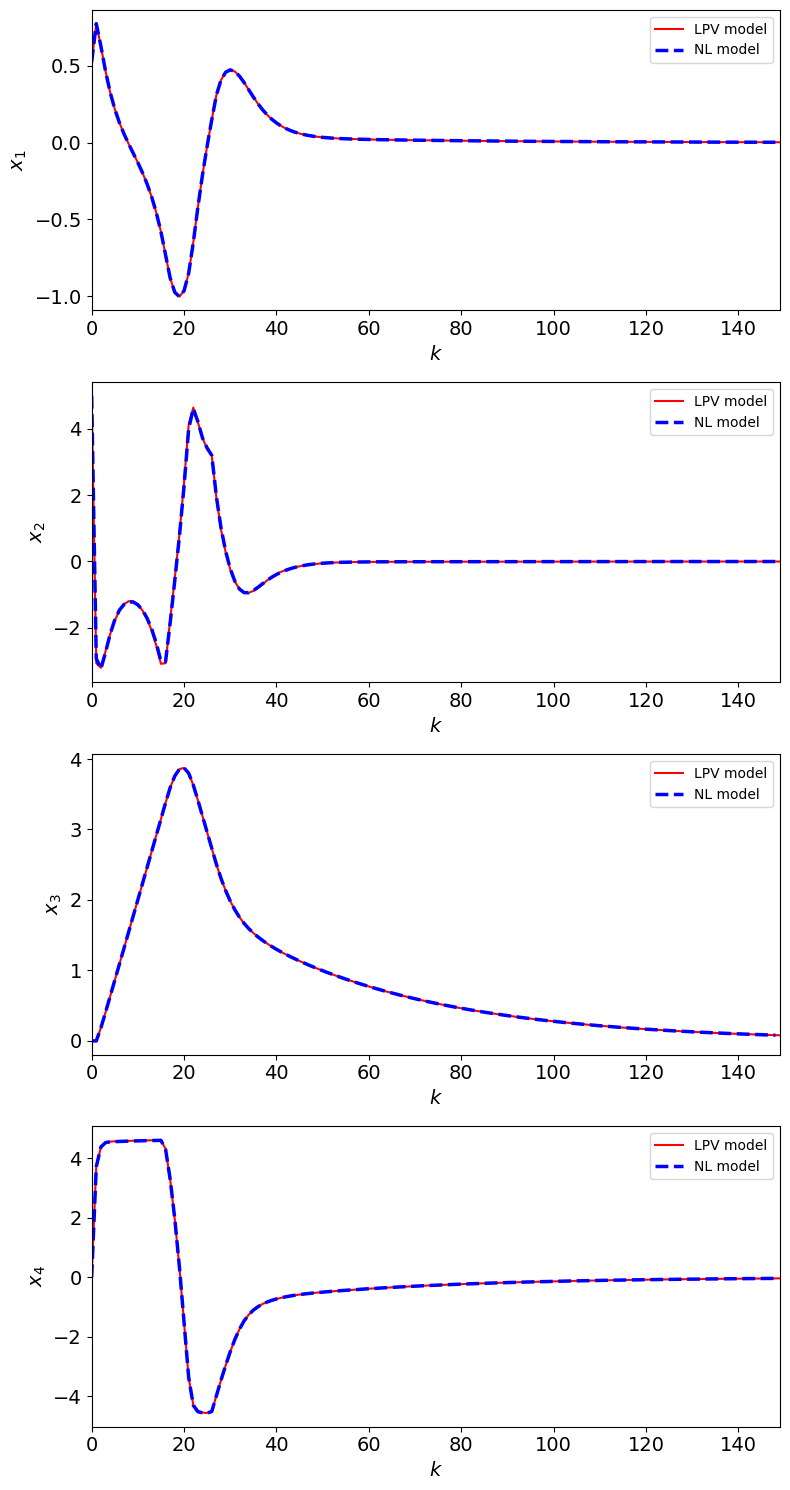

In [27]:
# State variables 
X_comp_fig = np.zeros(Xfig.shape)

for num, tet in enumerate(sch_pred_fig):
    X_comp_fig[num, :] = (tet[0] * Res['A1'] + Res['A0']).dot(Xfig[num,:]) + (tet[0] * Res['B1'] + Res['B0']).dot(Ufig[num,:]) 

X_comp_fig = np.insert(X_comp_fig, 0, np.array([np.pi/6, 5, 0, 0]), axis=0)
    
fig, axs = plt.subplots(4,1, figsize=(8,15))

for ind in range(4):
    axs[ind].plot(X_comp_fig[:, ind],'r', label='LPV model' )
    axs[ind].plot(Xfig[:, ind], 'b--', linewidth=2.5, label='NL model')
    axs[ind].set_xlabel(r'$k$', size=14)
    axs[ind].xaxis.set_tick_params(labelsize=14)
    axs[ind].yaxis.set_tick_params(labelsize=14)
    axs[ind].set_xlim(0,149)
    axs[ind].legend()
    

axs[0].set_ylabel(r'$x_1$', size=14)
axs[1].set_ylabel(r'$x_2$', size=14)
axs[2].set_ylabel(r'$x_3$', size=14)
axs[3].set_ylabel(r'$x_4$', size=14)
plt.tight_layout()
plt.savefig('states.eps')